# Sensitivity test
## wMed basin evolution during reconnection of a filled-Mediterranean

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import pandas as pd
import gsw

## Upload data files here

In [21]:
KE             = np.loadtxt(fname="SensitivityTest_wMed_flow_KE.txt") # Flow energy entering the wMed (From Script 12)
BPEad_Med      = np.loadtxt(fname="ST_Added_BPE.txt")                 # Added BPE  (From Script 13)
SLrise_Med     = np.loadtxt(fname="SensitivityTest_SL_rise_wMed.txt") # Rise of basin level (From Script 12)
Discharge      = np.loadtxt(fname="SensitivityTest_Discharge.txt")    # Flow discharge (From Script 12)
Hypsometry_med = np.loadtxt(fname="Hypsometry_Stage3_evolution.txt")  # Reconstructed Mediterranean hypsometry 
                #(This file contains wMed hypsometry below the level of Sicily sill, and whole-Mediterranean hypsometry above)

## Setting parameters

In [22]:
S_Marine = 36.5   # Atlantic water salinity [PSU]
T_Brine  = 20     # Brine temperature [degrees Celcius]
g        = 9.81   # Acceleration due to gravity [m s^-2]
Mix_Ef   = 1      # Mixing efficiency
rho_SW   = 1027   # Inflowing sea-water density [kg m^-3]

d40      = (gsw.density.rho_t_exact ([40],[T_Brine],[0]))   # Density at 40 PSU salinity
d140     = (gsw.density.rho_t_exact ([140],[T_Brine],[0]))  # Density at 140 PSU salinity

dzArray = np.linspace(0.5,3223.5,3224)   # Creates an array of mid-layer depths

Area         = (Hypsometry_med[:,1])*10**12  # Gives area with depth from surface towards bottom
Vol_Med      = (Hypsometry_med[:,3])*10**12  # Gives the cumulative volume from surface towards bottom
Volfrombot   = (Hypsometry_med[:,2])*10**12  # Gives the cumulative volume from bottom towards surface

SLArray      = [431]      # Value set to 1 m below Sicily sill to initiate the array
MixedD_med   = [rho_SW]   # Assume a thin layer of seawater on top 
MixedS_med   = [36.5]
Mdepthw      = []
Times        = []
Dprof        = []
Sprof        = []

Depth = Hypsometry_med[:,0]
DepthList = Depth.tolist()

## Setting the initial salinity profile

Initial salinity profile consists of a surface evaporated-Paratethyan water layer down to 560 m (40 PSU salinity), and a deeper brine below 1750 m (140 PSU).

Between 560m and 1750 m, salinity is linearly increased to obtain a conservative estimation.

(0, 1150)

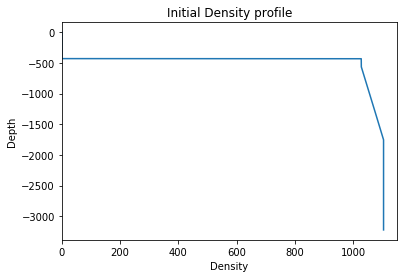

In [23]:
delta_Depth = 1751-561              # Thickness of layer between Paratethyan surface water and deeper brine
dS          = (140-40)/delta_Depth  # Salinity increment per meter

# Arrays to create the salinity profile
Salmid = []
dlist2=[]
i=40
while i<=140:
    i=i+dS
    Salmid.append(i)
    dlist2.append((gsw.density.rho_t_exact ([i],[T_Brine],[0])))
    
Salinity =np.where(Depth<431,0.0,140.0)
Salinity[431:561]=40.0 # Evaporated Paratethyan water
Salinity[561:1751]=Salmid

# Salinity-density profile conversion
Denmid =  (gsw.density.rho_t_exact ([Salmid],[T_Brine],[0]))
Density =np.where(Depth<431,0.0,d140)
Density[431:561]=d40
Density[561:1751]=Denmid

plt.figure()
plt.title('Initial Density profile')
plt.ylabel('Depth')
plt.xlabel('Density')
plt.plot(Density,-Depth)
plt.xlim([0,1150])


## Calculating parameters

Code used here is similar to that in Script 5 and 7, with same concepts.

Mixing efficiency is set to 1 (100% of inflow KE available for mixing), to get the maximum possible mixing depth.
Refer to Script 5 explanation for details.

(38, 150)

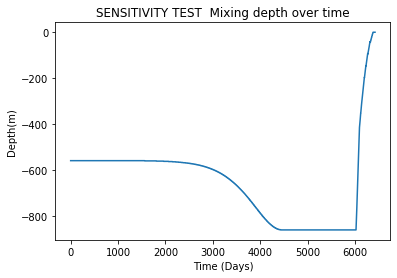

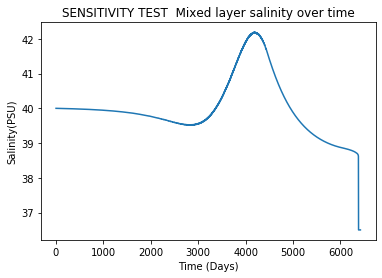

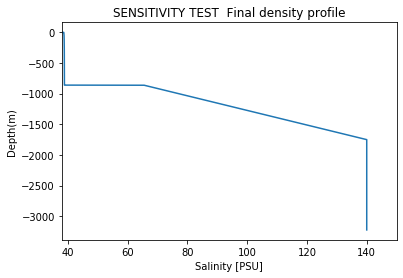

In [32]:
t = 1  # Starting time   
SLtrunc_Med = np.trunc(SLrise_Med) 
KEAv = KE*Mix_Ef

SLArray      = [431]      # Value set to 1 m below Sicily sill to initiate the array
MixedD_med   = [rho_SW]   # Assume a thin layer of seawater on top 
MixedS_med   = [36.5]
Mdepth_med   = []         # Appends daily mixing depth [m]
Times        = []         # Appends time [days]
Dprof        = []         # Appends final density profile
Sprof        = []         # Appends final salinity profile

# SALINITY AND DENSITY PROFILES REPEATED HERE TO AVOID UPDATING OF THE PROFILES DURING LOOPING

Salinity =np.where(Depth<431,0.0,140.0)
Salinity[431:561]=40.0 # Evaporated Paratethyan water
Salinity[561:1751]=Salmid

# Salinity-density profile conversion
Denmid =  (gsw.density.rho_t_exact ([Salmid],[T_Brine],[0]))
Density =np.where(Depth<431,0.0,d140)
Density[431:561]=d40
Density[561:1751]=Denmid

while t<6421:  # Basin refill duration 6420 days
    
    if t == 0:
        empty_VolwMed = Vol_Med[(int(SLtrunc_Med[t-1])+1)] # empty_VolwMed is the total volume of the empty space above basin surface,
        
    else:
        
        empty_VolwMed = Vol_Med[(int(SLtrunc_Med[t-1]))] 

    SL_Med = SLrise_Med[t-1]            # True sea level  (Daily sea level) of the PREVIOUS day
    
    SLt_Med = int(SLtrunc_Med[t-1])     # Truncated sea level at a given time
    SLNext = SLrise_Med[t-1]
    SLNextTrunc = SLtrunc_Med[t]        # Truncated sea level of following day     

    AddedBPE = BPEad_Med[t-1]           # Total BPE of the daily added sea water layer
    Dis      = Discharge[t]*3600*24     # Daily discharge
    
    dHwMed = (SLt_Med+1)-(SLArray[-1])  # thickness of water layer in the top incompletely-filled layer
    AreadHw = (Area[SLt_Med+1])         # area of the top incompletely-filled layer
    VoldHwMed = dHwMed*AreadHw          # Volume of fluids in top incompletely-filled layer
    
    SLArray.append(SL_Med)
    
    # Emptying all the arrays in the loop to keep the script running
    
    MixD_med = []
    Product_AreaHt = []
    Volarray = []
    BPEMix = []
    BPEi_Med = []
    delta_BPE = []
    Depthm = []
    D_MixedLayer = []
    MixingDepth_Med = []
    BPE_mixed = []
    Mixed_D = []
    indexa = []
    indexb = []
    DenVolw = []
    DenVolTw = []
    Sal_Vol = []
    SalVol_cumulative = []
    Mixed_Sal = []
    BPE_Total = []
    BPETop = []
    Mixed_D = []
    
    # Following 4 lines calculate the initial BPE profile (Cumulative)

    BPEi_Med = -(Area*Density*g*(Depth-(SL_Med-0.5))) #
    
    BPEicum = np.cumsum(BPEi_Med)
    
    BPETop = ((dHwMed/2)**2)*(AreadHw)*(MixedD_med[-1])*g
    
    BPE_Total = np.where(BPEicum!=0.0,BPEicum+ AddedBPE+ BPETop,0.0)  # Total initial BPE at each layer
    
    # Following 9 lines calculate the BPE after mixing (Cumulative)
    
    Sal_Vol = np.where(Salinity!=0, (Salinity*(Area)),0)  # Computes total salt content of each layer
    SalVol_cumulative = np.cumsum(Sal_Vol)

    # Computes possible mixed salinity during progressive downward mixing at each layer
    Mixed_Sal = np.where(Salinity!=0,((Dis*S_Marine) + SalVol_cumulative+(VoldHwMed*(MixedS_med[-1])))/(Dis + (Vol_Med - empty_VolwMed)+VoldHwMed),0.0)
    
    Mixed_Sal = Mixed_Sal.tolist()

    # Converts salinity to density using GSW Function
    Mixed_D = np.where(Salinity!=0, (gsw.density.rho_t_exact ([Mixed_Sal],[T_Brine],[0])),0.0)
    
    MixD_med = np.array(Mixed_D).flatten()
    
    # product of layer area and mid-layer depth
    Product_AreaHt = np.where(MixD_med!=0,(dzArray - SL_Med)*Area,0)
    Product_cumulative= np.cumsum(Product_AreaHt)

    BPE_mixed = np.where(MixD_med!=0,-(MixD_med*(Product_cumulative-Product_cumulative[SLt_Med])*g)+(AddedBPE*(MixD_med/rho_SW))+(BPETop*(MixD_med/rho_SW)) ,0)
    
    # PROFILE of the change in BPE at each 1 meter level below surface
    
    delta_BPE = (np.subtract(BPE_mixed,BPE_Total))

    
    for i,j,j0 in zip(delta_BPE, Depth, MixD_med):  # To calculate the mixing depth to the closest upper layer bottom.
        
        if i<(KEAv[t]):
            Depthm.append(j)
            D_MixedLayer.append(j0)

    MixingDepth_Med = np.max(Depthm)   # Daily mixing depth [m]
    Mixed_D = np.max(D_MixedLayer)     # Mixed layer density [kg^m-3]
    
    Dindex = np.where(MixD_med == Mixed_D)
    Dind = (Dindex[0])
    Dind = int(Dind[0])
    
    if Dind == 0:
        MixSal = 36.5
        Mixed_D = rho_SW
    else:
        MixSal = Mixed_Sal[Dind]
        Mixed_D = Mixed_D
        
    MixedS_med.append(MixSal)   # Mixed layer salinity
    MixedD_med.append(Mixed_D)
    #print ('Lower limit of the mixed layer is',MixingDepth_Med,'meters') 
    #print ('Thickness of the mixed layer is',(MixingDepth_Med-SL_Med),'meters') 
    #print ('Density of the mixed layer is',Mixed_D, MixSal) 
    #print('energy',KE[t])
    #print(dd)
    
    # Updating the density and salinity profiles after mixing 
    if Dind == 0:
        indexa = DepthList.index(SLt_Med+2)
      
    else:

        indexa = DepthList.index(SLNextTrunc+1)
    if MixingDepth_Med == 3223:
        indexb = DepthList.index(MixingDepth_Med)
    else:
        indexb = DepthList.index(MixingDepth_Med+1)
    
    Density2 = Density
    Density2[indexa:indexb]=Mixed_D
    
    Density = Density2
    
    Salinity2 = Salinity
    Salinity2[indexa:indexb]=MixSal
    
    Salinity = Salinity2
    
    Mdepth_med.append(-MixingDepth_Med)  
    Times.append(t)

    t=t+1

    if t%100 == 0:   # Use this to save salinity profile at 100-day intervals
        
        filename = 'Profile_%06d.txt'%t
        #print('NOW',filename)
        #np.savetxt(filename,Salinity,fmt="%s")
        
Sprof.append(Salinity)
dpr = Salinity.tolist()
Dprof.append(Density)
dpr2 = Density.tolist()
#np.savetxt("Sprofile ST 1ME.txt", np.array(dpr), fmt="%s")
#np.savetxt("Dprofile ST 1ME.txt", np.array(dpr2), fmt="%s")
#np.savetxt("Mdepth ST 1ME.txt", np.array(Mdepth_med), fmt="%s")
#np.savetxt("Time.txt", np.array(Times))
#np.savetxt("Salinity with time ST 1ME.txt", np.array(MixedS_med))


plt.figure()
plt.title ('SENSITIVITY TEST  Mixing depth over time')
plt.xlabel('Time (Days)')
plt.ylabel('Depth(m)')
plt.plot(Times,Mdepth_med)
plt.figure()
plt.title ('SENSITIVITY TEST  Mixed layer salinity over time')
plt.xlabel('Time (Days)')
plt.ylabel('Salinity(PSU)')
plt.plot(Times,MixedS_med[1:])
plt.figure()
plt.title ('SENSITIVITY TEST  Final density profile')
plt.xlabel('Salinity [PSU]')
plt.ylabel('Depth(m)')
plt.plot(Salinity,-(Depth))
#plt.xlim([38,39.4]) # Use this for a closer view
plt.xlim([38,150])

## Interpretation

During refilling of a more filled-Mediterranean, energy release is much less (>50 times smaller) compared to a catastrophic termination. This energy is not sufficient to erode and transfer wMed brines towards eMed, even at a 100% mixing efficiency.